In [0]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,MaxAbsScaler,Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [0]:
df_vg = pd.read_csv("https://raw.githubusercontent.com/thedanieljk/Data301FinalProject/master/df_vg_final.csv")
df_vg = df_vg.iloc[:539] #only 539 have recorded sales (over 10,000)
df_vg

,Rank,Name,Year,Genre,Publisher,Developer,Critic_Score,User_Score,Global_Sales
0,1,Grand Theft Auto V,2014.0,Action,Rockstar Games,Rockstar North,9.0,9.0,8.72
1,2,Call of Duty: Black Ops 3,2015.0,Shooter,Activision,Treyarch,NaN,NaN,7.37
2,3,Call of Duty: WWII,2017.0,Shooter,Activision,Sledgehammer Games,NaN,NaN,6.23
3,4,Red Dead Redemption 2,2018.0,Action-Adventure,Rockstar Games,Rockstar Games,NaN,NaN,5.77
4,5,Minecraft,2014.0,Misc,Microsoft Studios,Mojang,NaN,NaN,5.43
...,...,...,...,...,...,...,...,...,...
534,535,V-Rally 4,2018.0,Racing,Bigben Interactive,Kylotonn,NaN,NaN,0.01
535,536,Jagged Alliance: Rage!,2018.0,Strategy,THQ Nordic,Cliffhanger Productions,NaN,NaN,0.01
536,537,Ziggurat,2015.0,Shooter,Milkstone Studios,Milkstone Studios,NaN,NaN,0.01
537,538,ATV Renegades,2017.0,Racing,Nighthawk Interactive,Nighthawk Interactive,NaN,NaN,0.01


In [0]:
def get_cv_err_categorical(features):
  ct = make_column_transformer(
      (OneHotEncoder(handle_unknown="ignore"), features),
      remainder="passthrough"
  )

  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=3)
  )
  cv_errs = -cross_val_score(pipeline,
                             X=df_vg[features],
                             y=df_vg["Global_Sales"],
                             scoring="neg_mean_squared_error",cv=2)
  return cv_errs.mean()



errs = pd.Series()
for features in [["Genre"],["Publisher"],["Developer"]]:
  errs[str(features)] = get_cv_err_categorical(features)
errs

['Genre']         6.772372
['Publisher']    15.706889
['Developer']    22.778455
dtype: float64

I began with seeing which of the categorical was the best estimate of Global Sales. Genre won with an MSE of 8.95. Publisher came 2nd with an MSE of 12.93. Developer was in a distant last with an MSE of 24.48. (k=3)

In [0]:
def get_cv_err(features):
  ct = make_column_transformer(
      (OneHotEncoder(handle_unknown="ignore"), features),
      remainder="passthrough"
  )

  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=3)
  )
  cv_errs = -cross_val_score(pipeline,
                             X=df_vg[features],
                             y=df_vg["Global_Sales"],
                             scoring="neg_mean_squared_error",cv=4)
  return cv_errs.mean()



errs = pd.Series()
for features in [["Genre","Publisher"],["Genre","Developer"],["Publisher","Developer"],["Genre","Publisher","Developer"]]:
  errs[str(features)] = get_cv_err(features)
errs

['Genre', 'Publisher']                  6.595095
['Genre', 'Developer']                  6.791547
['Publisher', 'Developer']             10.153461
['Genre', 'Publisher', 'Developer']     5.464975
dtype: float64

Tried some combinations of categorical variables. For k=3, using all categorical variables (genre, publisher, developer) gave me the lowest mse of 5.46 by a significant amount.

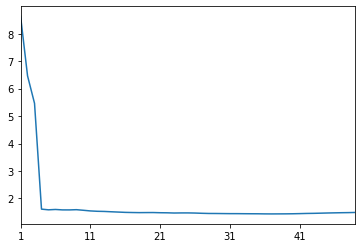

In [0]:
def get_cv_err_k(k):
  ct = make_column_transformer(
      (OneHotEncoder(handle_unknown="ignore"), ["Genre","Publisher","Developer"]),
      remainder="passthrough"
  )

  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=k)
  )
  cv_errs = -cross_val_score(pipeline,
                             X=df_vg[["Genre","Publisher","Developer"]],
                             y=df_vg["Global_Sales"],
                             scoring="neg_mean_squared_error",cv=4)
  return cv_errs.mean()



errs = pd.Series()
for k in range(1,50):
  errs[str(k)] = get_cv_err_k(k)
errs.plot(kind="line")

Here we have a plotted chart of k-values for 1 through 50. Picking k=3 was a poor choice it seems like. A higher k, such as one in the 20's, leads to an mse of ~1.5.

Now let's take a look at different metrics and k-values in order to find the best parameters for k-nearest neighbors.

In [0]:
def get_cv_err_k_metrics(k,metrics):
  ct = make_column_transformer(
      (OneHotEncoder(handle_unknown="ignore"), ["Genre","Publisher","Developer"]),
      remainder="passthrough"
  )

  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=k,metric=metrics)
  )
  cv_errs = -cross_val_score(pipeline,
                             X=df_vg[["Genre","Publisher","Developer"]],
                             y=df_vg["Global_Sales"],
                             scoring="neg_mean_squared_error",cv=4)
  return cv_errs.mean()



errs = pd.Series()

for k in range(1,50):
  for metric in ["euclidean","manhattan","minkowski"]:
    errs[str(k) + " " + str(metric)] = get_cv_err_k_metrics(k,metric)
print(errs)

1 euclidean     8.634740
1 manhattan     8.634740
1 minkowski     8.634740
2 euclidean     6.463758
2 manhattan     6.463758
                  ...   
48 manhattan    1.486143
48 minkowski    1.486143
49 euclidean    1.491822
49 manhattan    1.491822
49 minkowski    1.491822
Length: 147, dtype: float64


In [0]:
print(errs)

1 euclidean     8.634740
1 manhattan     8.634740
1 minkowski     8.634740
2 euclidean     6.463758
2 manhattan     6.463758
                  ...   
48 manhattan    1.486143
48 minkowski    1.486143
49 euclidean    1.491822
49 manhattan    1.491822
49 minkowski    1.491822
Length: 147, dtype: float64


Looking at different metrics made no impact.

Here I took a linear regression instead of a k-nearest neighbors regression. Linear appears to be a better predictor, with all MSE's around the 1.5-1.6 range.

In [0]:
def get_cv_err_linear(features):
  ct = make_column_transformer(
      (OneHotEncoder(handle_unknown="ignore"), features),
      remainder="passthrough"
  )

  pipeline = make_pipeline(
      ct,
      StackingRegressor([
    ("linear", LinearRegression()), 
    ("knn", KNeighborsRegressor(n_neighbors=30))],
    final_estimator=LinearRegression()
)
  )
  cv_errs = -cross_val_score(pipeline,
                             X=df_vg[features],
                             y=df_vg["Global_Sales"],
                             scoring="neg_mean_squared_error",cv=2)
  return cv_errs.mean()



errs = pd.Series()
for features in [["Genre","Publisher"],["Genre","Developer"],["Publisher","Developer"],["Genre","Publisher","Developer"]]:
  errs[str(features)] = get_cv_err_linear(features)
errs

['Genre', 'Publisher']                 2.108843
['Genre', 'Developer']                 1.977563
['Publisher', 'Developer']             2.217341
['Genre', 'Publisher', 'Developer']    2.177001
dtype: float64

Tried creating a stacked model and got worse results.

Unfortunately I'm a bit saddened by the poor results. A model being off by ~1.2 million sales on average is not a good model. I think this is a case where your model is only going to be as good as your data and I didn't have enough high quality data. More games, maybe taking reviews from a more reputable source like IGN, or including the description in games may have led to a much better model.